<a href="https://colab.research.google.com/github/liubruce11/BA820-TeamB7/blob/allen-pet-cats/B1_Team07_AllenM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BA820 Project M2**
**Pet Cats UK**

Allen Chiu

## **Objective:**  
This notebook focuses on diving deeper into this business question:

What distinct profiles of cats exhibit extreme prey-catching behavior, and what targeted recommendations can be provided to owners, based on their demographic, environmental, and behavioral characteristics, to effectively manage or mitigate this behavior?

# **1. Data Overview**

The analysis uses two linked tables:
- `cats_uk.csv`: high-frequency GPS movement observations
- `cats_uk_reference.csv`: cat-level biological and household attributes

Each movement observation is associated with a single cat via `tag_id`, enabling analysis at both the event and individual levels.


In [27]:
# import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# pulls dataset
url1 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk.csv"

cats_uk = pd.read_csv(url1)

url2 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk_reference.csv"

cats_uk_ref = pd.read_csv(url2)

### **1.1 Merge two datasets into one**

In [29]:
cats_cols = ['tag_id', 'location_long', 'location_lat', 'ground_speed', 'height_above_ellipsoid']
ref_cols = [
    "tag_id", "animal_id", "animal_sex", "age_years", "hrs_indoors",
    "hunt", "prey_p_month", "food_dry", "food_wet", "food_other",
    "n_cats", "animal_reproductive_condition"
]
ref_small = cats_uk_ref[ref_cols]
cats_small = cats_uk[cats_cols]
cats_merged = cats_small.merge(ref_small, on="tag_id", how="left")

I merged the two datasets on tag_id and keeping the features relevant for my analysis, I think having one dataset can help with doing my part of the analysis. In M3 if other members of the group need other features, will adjust accordingly.

In [30]:
cats_merged.nunique()

,0
tag_id,101
location_long,14968
location_lat,9396
ground_speed,507
height_above_ellipsoid,11560
animal_id,101
animal_sex,2
age_years,16
hrs_indoors,5
hunt,2


In [31]:
cats_merged

,tag_id,location_long,location_lat,ground_speed,height_above_ellipsoid,animal_id,animal_sex,age_years,hrs_indoors,hunt,prey_p_month,food_dry,food_wet,food_other,n_cats,animal_reproductive_condition
0,Ares,-5.113851,50.170315,684,154.67,Ares,m,3.0,7.5,NaN,0.0,True,True,False,2,Neutered
1,Ares,-5.113851,50.170315,936,154.67,Ares,m,3.0,7.5,NaN,0.0,True,True,False,2,Neutered
2,Ares,-5.113730,50.169876,2340,81.35,Ares,m,3.0,7.5,NaN,0.0,True,True,False,2,Neutered
3,Ares,-5.113774,50.169827,0,67.82,Ares,m,3.0,7.5,NaN,0.0,True,True,False,2,Neutered
4,Ares,-5.114247,50.170139,4896,118.03,Ares,m,3.0,7.5,NaN,0.0,True,True,False,2,Neutered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18210,Millie-Tag,-4.521489,50.869320,1260,144.66,Millie,f,3.0,12.5,True,7.5,False,True,True,2,Spayed
18211,Millie-Tag,-4.521498,50.869289,16380,136.60,Millie,f,3.0,12.5,True,7.5,False,True,True,2,Spayed
18212,Millie-Tag,-4.521803,50.869438,4500,160.97,Millie,f,3.0,12.5,True,7.5,False,True,True,2,Spayed
18213,Millie-Tag,-4.521946,50.869392,1044,179.81,Millie,f,3.0,12.5,True,7.5,False,True,True,2,Spayed


In [34]:
cats_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18215 entries, 0 to 18214
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tag_id                         18215 non-null  object 
 1   location_long                  18215 non-null  float64
 2   location_lat                   18215 non-null  float64
 3   ground_speed                   18215 non-null  int64  
 4   height_above_ellipsoid         18215 non-null  float64
 5   animal_id                      18215 non-null  object 
 6   animal_sex                     18215 non-null  object 
 7   age_years                      18079 non-null  float64
 8   hrs_indoors                    18215 non-null  float64
 9   hunt                           17039 non-null  object 
 10  prey_p_month                   18215 non-null  float64
 11  food_dry                       18215 non-null  bool   
 12  food_wet                       18215 non-null 

### **1.2 Impute the missing values with median, modes**

In [35]:
# Impute 'age_years' with median
median_age = cats_merged['age_years'].median()
cats_merged['age_years'].fillna(median_age, inplace=True)

# Impute 'hunt', 'animal_reproductive_condition', and 'food_other' with modes
mode_hunt = cats_merged['hunt'].mode()[0]
cats_merged['hunt'].fillna(mode_hunt, inplace=True)

mode_reproductive_condition = cats_merged['animal_reproductive_condition'].mode()[0]
cats_merged['animal_reproductive_condition'].fillna(mode_reproductive_condition, inplace=True)

mode_food_other = cats_merged['food_other'].mode()[0]
cats_merged['food_other'].fillna(mode_food_other, inplace=True)

# Verify that there are no more missing values in these columns
display(cats_merged[['hunt', 'animal_reproductive_condition', 'food_other', 'age_years']].isna().sum())

/tmp/ipython-input-1923695291.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cats_merged['age_years'].fillna(median_age, inplace=True)
/tmp/ipython-input-1923695291.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

,0
hunt,0
animal_reproductive_condition,0
food_other,0
age_years,0


In [8]:
cats_merged.describe()

,location_long,location_lat,ground_speed,height_above_ellipsoid,age_years,hrs_indoors,prey_p_month,n_cats
count,18215.000000,18215.000000,18215.000000,18215.000000,18215.000000,18215.000000,18215.000000,18215.000000
mean,-4.988242,50.296238,1911.484381,103.648265,5.606917,11.170876,4.296733,2.112709
std,0.301499,0.158353,4592.574178,245.705665,3.478112,5.274250,5.315812,0.970907
min,-5.758854,50.103519,0.000000,-550.070000,0.000000,2.500000,0.000000,1.000000
25%,-5.157051,50.153644,396.000000,48.870000,3.000000,7.500000,0.500000,1.000000
50%,-5.073365,50.236397,1080.000000,80.920000,5.000000,12.500000,3.000000,2.000000
75%,-4.795648,50.428098,2232.000000,119.430000,8.000000,12.500000,3.000000,3.000000
max,-4.208614,50.882217,277092.000000,8388.260000,16.000000,22.500000,17.500000,4.000000


### **1.3 Create a fraction of the dataset for better computation**

In [9]:
#Create a fraction of the dataset for better computation
cats_frac = cats_merged.sample(frac=0.25, random_state=42)

cats_frac.describe()

,location_long,location_lat,ground_speed,height_above_ellipsoid,age_years,hrs_indoors,prey_p_month,n_cats
count,4554.000000,4554.000000,4554.000000,4554.000000,4554.000000,4554.000000,4554.000000,4554.000000
mean,-4.984700,50.299437,1911.272727,103.234021,5.590690,11.185771,4.279534,2.113966
std,0.304455,0.159449,4926.581893,244.304332,3.461852,5.285799,5.323711,0.973157
min,-5.554315,50.116287,0.000000,-535.020000,0.000000,2.500000,0.000000,1.000000
25%,-5.175026,50.155372,396.000000,49.545000,3.000000,7.500000,0.500000,1.000000
50%,-5.071888,50.236702,1080.000000,81.275000,5.000000,12.500000,3.000000,2.000000
75%,-4.794304,50.436455,2232.000000,119.650000,8.000000,12.500000,3.000000,3.000000
max,-4.208614,50.870781,277092.000000,8388.260000,16.000000,22.500000,17.500000,4.000000


### **1.4 Create Pairplot EDA**

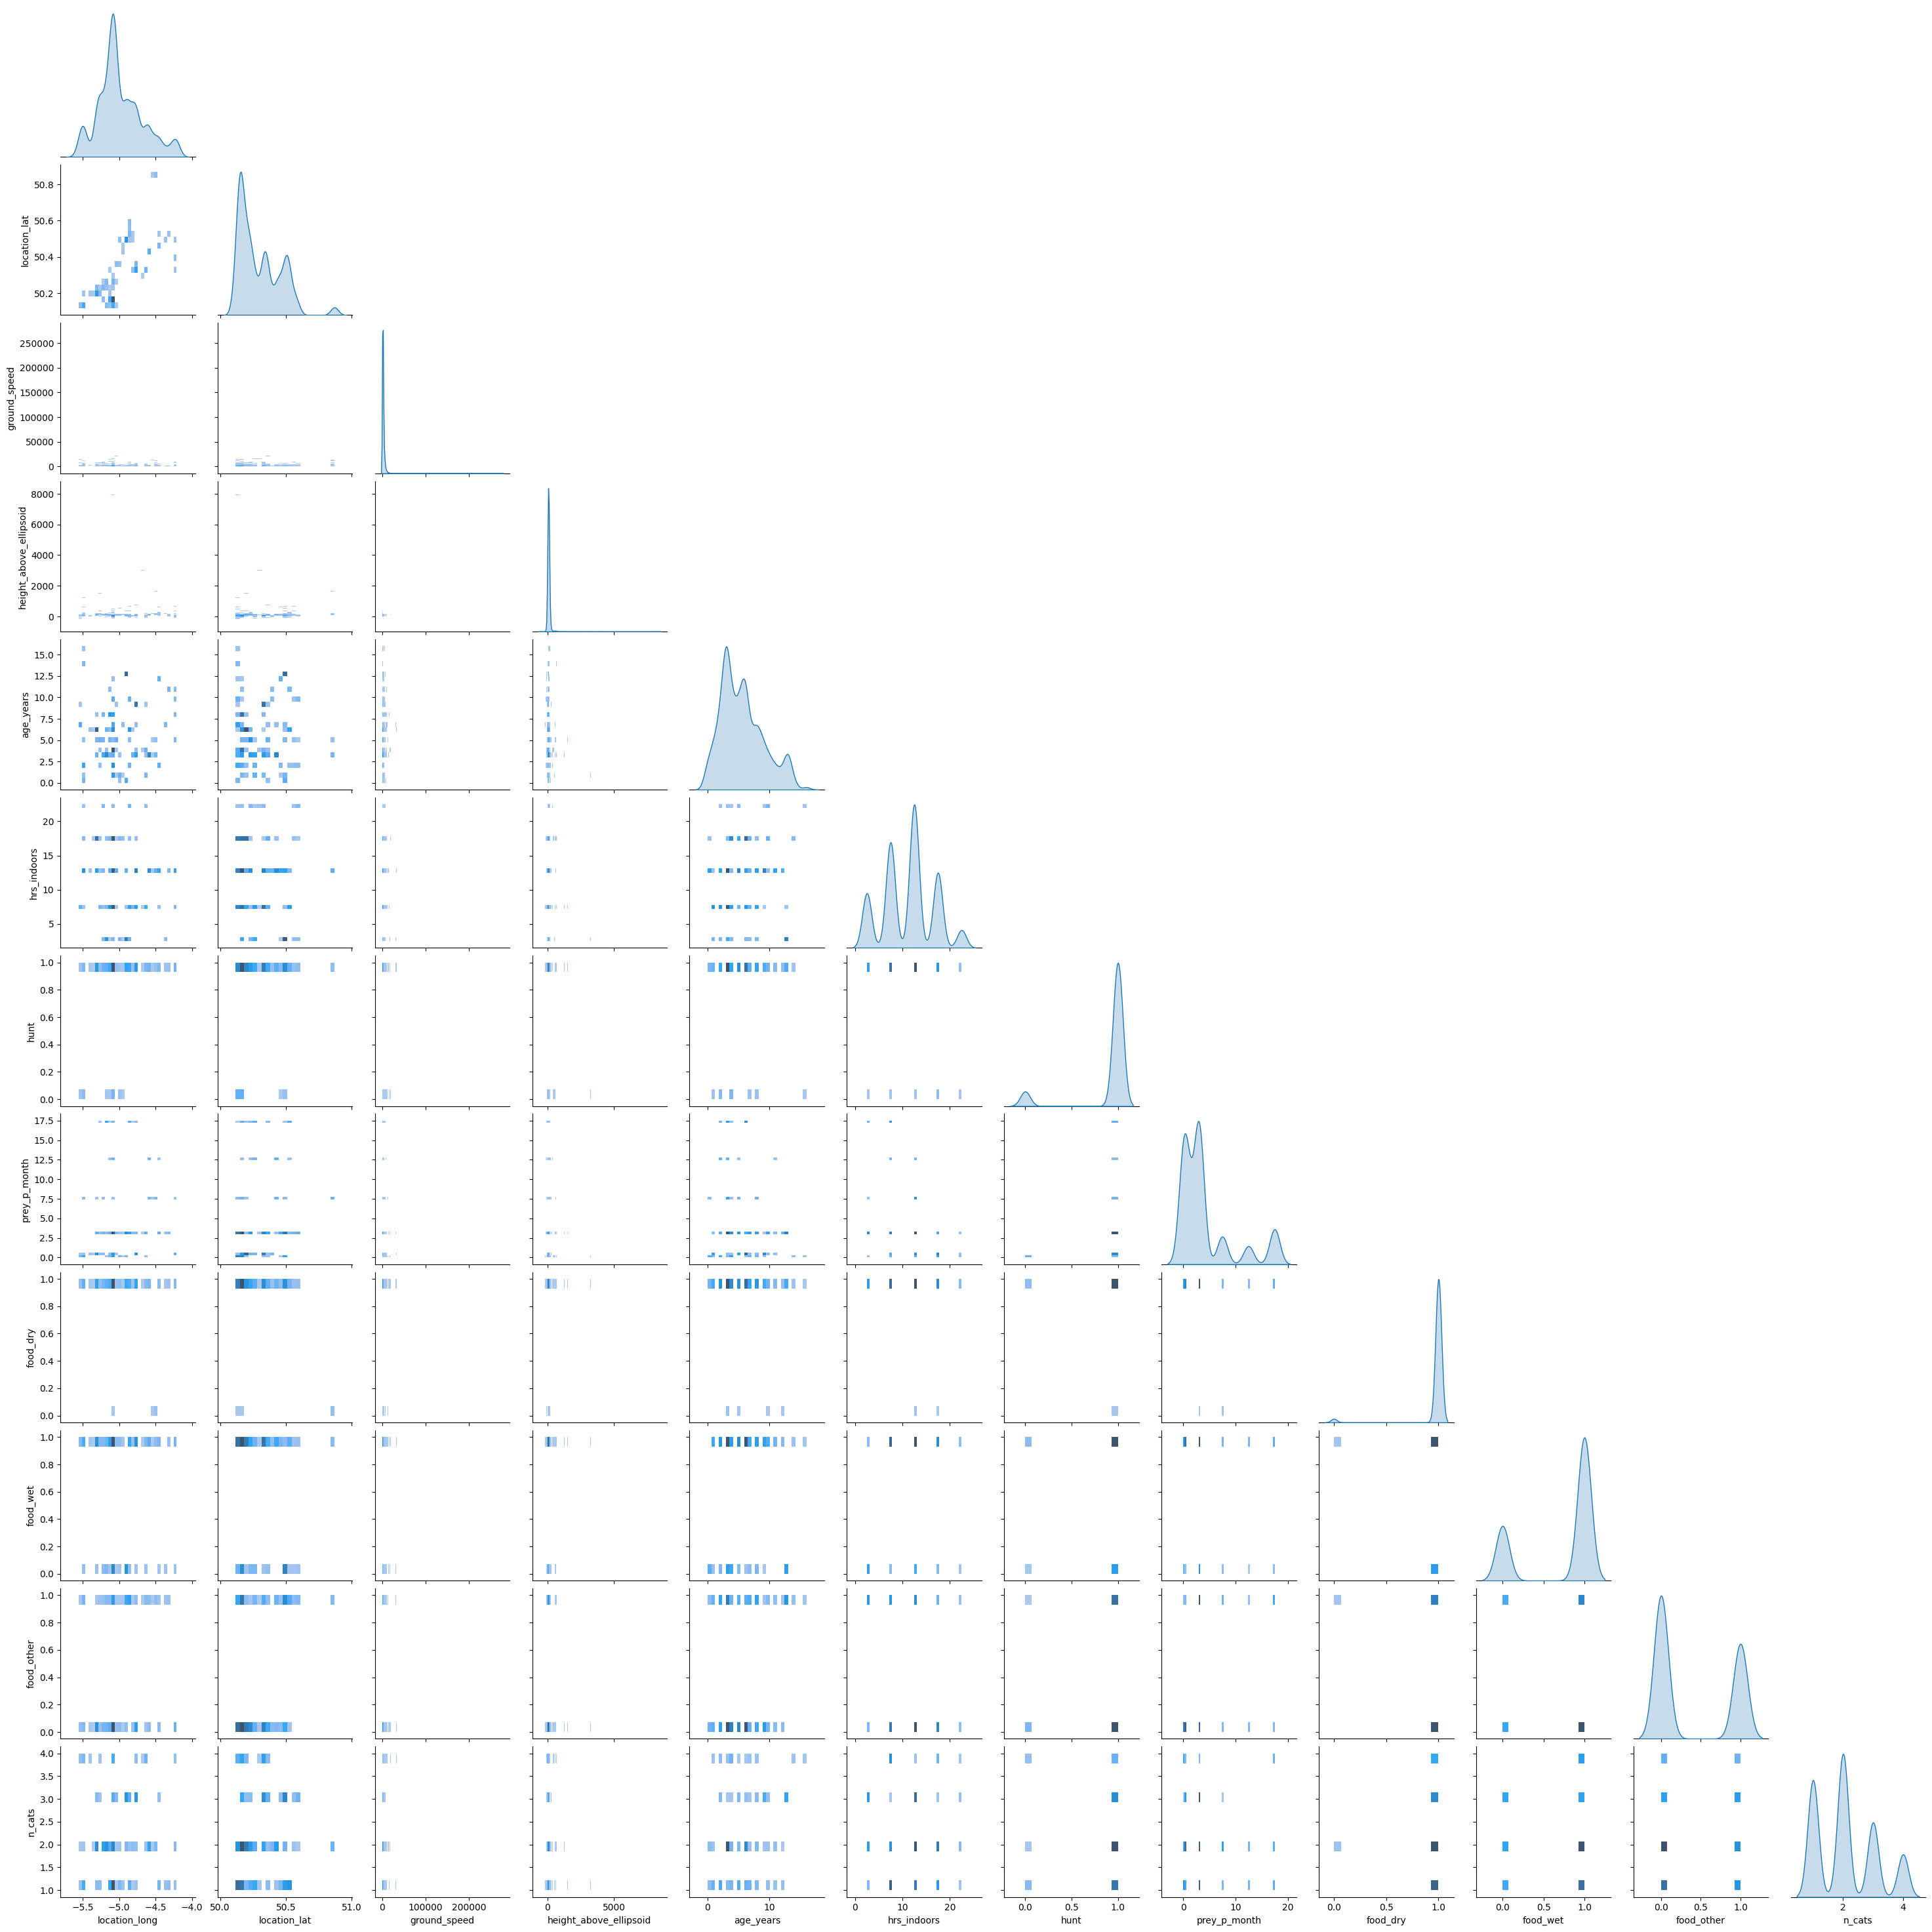

In [10]:
sns.pairplot(cats_frac, kind="hist", diag_kind="kde", corner=True)

There are some outliers skewing the histograms, ominent especially in ground speed, height above ellipsoid and prey per month. This observation confirms that the average might not be a very representative measure for these features.

### **1.5 Create a new subset extreme_cats**

In [43]:
prey_threshold = cats_merged['prey_p_month'].quantile(0.90)
extreme_cats = cats_merged[cats_merged['prey_p_month'] >= prey_threshold]
display(extreme_cats.head())
print(f"Shape of extreme_cats DataFrame: {extreme_cats.shape}")

,tag_id,location_long,location_lat,ground_speed,height_above_ellipsoid,animal_id,animal_sex,age_years,hrs_indoors,hunt,prey_p_month,food_dry,food_wet,food_other,n_cats,animal_reproductive_condition
433,Jago,-5.072786,50.152359,3888,12.66,Jago,m,2.0,7.5,True,17.5,True,True,True,4,Neutered
434,Jago,-5.072977,50.153313,1836,137.19,Jago,m,2.0,7.5,True,17.5,True,True,True,4,Neutered
435,Jago,-5.073518,50.153030,972,36.98,Jago,m,2.0,7.5,True,17.5,True,True,True,4,Neutered
436,Jago,-5.073183,50.152740,0,64.10,Jago,m,2.0,7.5,True,17.5,True,True,True,4,Neutered
437,Jago,-5.072166,50.152809,9756,5.10,Jago,m,2.0,7.5,True,17.5,True,True,True,4,Neutered


Shape of extreme_cats DataFrame: (2749, 16)


### **1.6 Transform boolean values into integer**

In [12]:
selected_features = [
    'hrs_indoors', 'n_cats', 'age_years', 'animal_sex',
    'animal_reproductive_condition', 'food_dry', 'food_wet', 'food_other',
    'ground_speed', 'height_above_ellipsoid', 'location_long', 'location_lat'
]

features_df = extreme_cats[selected_features].copy()

boolean_cols = ['food_dry', 'food_wet', 'food_other']
for col in boolean_cols:
    features_df[col] = features_df[col].astype(int)

display(features_df.head())
features_df.info()

,hrs_indoors,n_cats,age_years,animal_sex,animal_reproductive_condition,food_dry,food_wet,food_other,ground_speed,height_above_ellipsoid,location_long,location_lat
433,7.5,4,2.0,m,Neutered,1,1,1,3888,12.66,-5.072786,50.152359
434,7.5,4,2.0,m,Neutered,1,1,1,1836,137.19,-5.072977,50.153313
435,7.5,4,2.0,m,Neutered,1,1,1,972,36.98,-5.073518,50.153030
436,7.5,4,2.0,m,Neutered,1,1,1,0,64.10,-5.073183,50.152740
437,7.5,4,2.0,m,Neutered,1,1,1,9756,5.10,-5.072166,50.152809


<class 'pandas.core.frame.DataFrame'>
Index: 2749 entries, 433 to 17431
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   hrs_indoors                    2749 non-null   float64
 1   n_cats                         2749 non-null   int64  
 2   age_years                      2749 non-null   float64
 3   animal_sex                     2749 non-null   object 
 4   animal_reproductive_condition  2749 non-null   object 
 5   food_dry                       2749 non-null   int64  
 6   food_wet                       2749 non-null   int64  
 7   food_other                     2749 non-null   int64  
 8   ground_speed                   2749 non-null   int64  
 9   height_above_ellipsoid         2749 non-null   float64
 10  location_long                  2749 non-null   float64
 11  location_lat                   2749 non-null   float64
dtypes: float64(5), int64(5), object(2)
memory usage: 2

# **2. Preprocessing for Unsupervised ML**




### **2.1 Scaling numerical features and encoding categorical features**

In [13]:
#Separate numerical and categorical columns
numerical_features_to_scale = ['hrs_indoors', 'n_cats', 'age_years', 'ground_speed', 'height_above_ellipsoid', 'location_long', 'location_lat', 'food_dry', 'food_wet', 'food_other']
categorical_features_to_encode = ['animal_sex', 'animal_reproductive_condition']

features_numerical = features_df[numerical_features_to_scale]
features_categorical = features_df[categorical_features_to_encode]

In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder


scaler = StandardScaler()

features_numerical_scaled = scaler.fit_transform(features_numerical)
features_numerical_scaled_df = pd.DataFrame(features_numerical_scaled, columns=numerical_features_to_scale, index=features_df.index)

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

features_categorical_encoded = encoder.fit_transform(features_categorical)
features_categorical_encoded_df = pd.DataFrame(features_categorical_encoded, columns=encoder.get_feature_names_out(categorical_features_to_encode), index=features_df.index)

#Concatenate the scaled numerical DataFrame and the one-hot encoded categorical DataFrame
features_preprocessed = pd.concat([features_numerical_scaled_df, features_categorical_encoded_df], axis=1)

display(features_preprocessed.head())
features_preprocessed.info()

,hrs_indoors,n_cats,age_years,ground_speed,height_above_ellipsoid,location_long,location_lat,food_dry,food_wet,food_other,animal_sex_f,animal_sex_m,animal_reproductive_condition_Neutered,animal_reproductive_condition_Spayed
433,0.124758,1.797031,-0.922989,0.907116,-0.481036,-0.475865,-1.273280,0.0,0.584491,0.862081,0.0,1.0,1.0,0.0
434,0.124758,1.797031,-0.922989,0.069868,0.148997,-0.476713,-1.265744,0.0,0.584491,0.862081,0.0,1.0,1.0,0.0
435,0.124758,1.797031,-0.922989,-0.282657,-0.357995,-0.479116,-1.267980,0.0,0.584491,0.862081,0.0,1.0,1.0,0.0
436,0.124758,1.797031,-0.922989,-0.679248,-0.220787,-0.477628,-1.270271,0.0,0.584491,0.862081,0.0,1.0,1.0,0.0
437,0.124758,1.797031,-0.922989,3.301350,-0.519285,-0.473111,-1.269726,0.0,0.584491,0.862081,0.0,1.0,1.0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 2749 entries, 433 to 17431
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   hrs_indoors                             2749 non-null   float64
 1   n_cats                                  2749 non-null   float64
 2   age_years                               2749 non-null   float64
 3   ground_speed                            2749 non-null   float64
 4   height_above_ellipsoid                  2749 non-null   float64
 5   location_long                           2749 non-null   float64
 6   location_lat                            2749 non-null   float64
 7   food_dry                                2749 non-null   float64
 8   food_wet                                2749 non-null   float64
 9   food_other                              2749 non-null   float64
 10  animal_sex_f                            2749 non-null   float6

# **3. Apply Unsupervised Machine Learning Methods**




### **3.1 Determine optimal number of clusters using the Elbow Method and Silhouette Score (for K-prototype)**




In [16]:
features_for_kproto = features_preprocessed.copy()
# Remove 'cluster' and 'cluster_kproto' columns if they exist (Did a lot of different clustering methods beforehand)
if 'cluster' in features_for_kproto.columns:
    features_for_kproto = features_for_kproto.drop(columns=['cluster'])
if 'cluster_kproto' in features_for_kproto.columns:
    features_for_kproto = features_for_kproto.drop(columns=['cluster_kproto'])

# Define the one-hot encoded categorical column names
categorical_col_names_kproto = [
    'food_dry', 'food_wet', 'food_other', 'animal_sex_f', 'animal_sex_m',
    'animal_reproductive_condition_Neutered', 'animal_reproductive_condition_Spayed'
]

# Get the numerical indices of these categorical columns
categorical_indices_kproto = [features_for_kproto.columns.get_loc(col) for col in categorical_col_names_kproto]

print("Shape of features_for_kproto after cleaning:", features_for_kproto.shape)
print("Categorical indices for K-Prototypes:", categorical_indices_kproto)

Shape of features_for_kproto after cleaning: (2749, 14)
Categorical indices for K-Prototypes: [7, 8, 9, 10, 11, 12, 13]


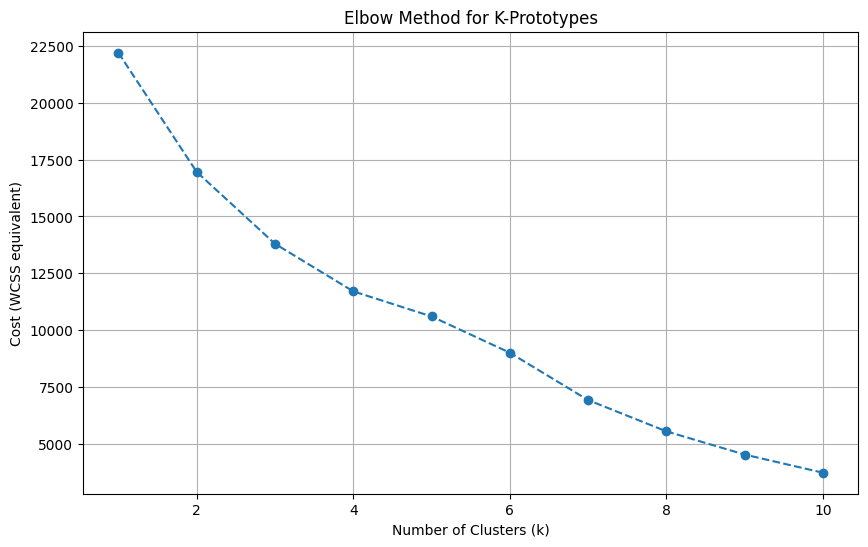

In [17]:
from kmodes.kprototypes import KPrototypes

cost_kproto = []
range_n_clusters_kproto = range(1, 11)

for n_clusters in range_n_clusters_kproto:
    kproto = KPrototypes(n_clusters=n_clusters, init='Cao', n_init=10, random_state=42)
    kproto.fit(features_for_kproto, categorical=categorical_indices_kproto)
    cost_kproto.append(kproto.cost_)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters_kproto, cost_kproto, marker='o', linestyle='--')
plt.title('Elbow Method for K-Prototypes')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost (WCSS equivalent)')
plt.grid(True)
plt.show()

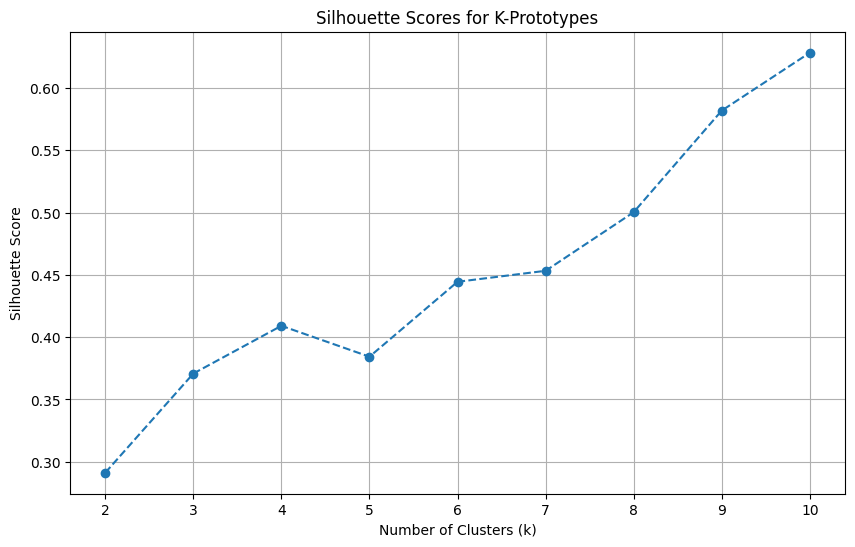

In [18]:
from sklearn.metrics import silhouette_score

silhouette_scores_kproto = []
range_n_clusters_kproto_silhouette = range(2, 11) # Silhouette score is not defined for k=1

for n_clusters in range_n_clusters_kproto_silhouette:
    kproto = KPrototypes(n_clusters=n_clusters, init='Cao', n_init=10, random_state=42)
    cluster_labels_kproto = kproto.fit_predict(features_for_kproto, categorical=categorical_indices_kproto)
    score = silhouette_score(features_for_kproto, cluster_labels_kproto)
    silhouette_scores_kproto.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters_kproto_silhouette, silhouette_scores_kproto, marker='o', linestyle='--')
plt.title('Silhouette Scores for K-Prototypes')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

The reason I chose to use k=3 is because for this business question, choosing 6 or 7 clusters is way too high. Even though we have a lot of rows of data, there are only 12 unique cats that are in the extreme_cats subset, hence using k=6 or 7 can lead to clustering among the unique cats. I also tried k=4, but figured it does not interpret as well.

### **3.2 Apply K-Prototypes Clustering**


In [19]:
pip install kmodes

In [20]:
from kmodes.kprototypes import KPrototypes
categorical_indices = [features_preprocessed.columns.get_loc(col) for col in [
    'animal_sex_f', 'animal_sex_m',
    'animal_reproductive_condition_Neutered', 'animal_reproductive_condition_Spayed'
]]

k_optimal_kprototypes = 3
kproto = KPrototypes(n_clusters=k_optimal_kprototypes, init='Huang', n_init=10, random_state=42)

# Fit the model and get cluster labels
cluster_labels_kproto = kproto.fit_predict(features_preprocessed, categorical=categorical_indices)

# Add the new cluster labels to the DataFrame
features_preprocessed['cluster_kproto'] = cluster_labels_kproto

# Recalculate cluster characteristics based on K-Prototypes clusters
cluster_characteristics_kproto = features_preprocessed.groupby('cluster_kproto').mean()
display(cluster_characteristics_kproto)
print("Shape of features_preprocessed after adding K-Prototypes clusters:", features_preprocessed.shape)
print("K-Prototypes cluster counts:")
display(features_preprocessed['cluster_kproto'].value_counts())

,hrs_indoors,n_cats,age_years,ground_speed,height_above_ellipsoid,location_long,location_lat,food_dry,food_wet,food_other,animal_sex_f,animal_sex_m,animal_reproductive_condition_Neutered,animal_reproductive_condition_Spayed
cluster_kproto,,,,,,,,,,,,,,
0,-0.113011,-0.600996,0.483976,-0.066301,-0.060673,-0.626143,-0.718648,0.0,0.167149,-1.159984,0.737500,0.262500,0.262500,0.737500
1,0.661079,-0.115077,0.098165,-0.023104,0.047819,1.147337,1.152222,0.0,0.377994,0.302949,0.340909,0.659091,0.659091,0.340909
2,-0.736347,0.799997,-0.651367,0.101775,0.003561,-0.812524,-0.718740,0.0,-0.671898,0.862081,0.000000,1.000000,1.000000,0.000000


Shape of features_preprocessed after adding K-Prototypes clusters: (2749, 15)
K-Prototypes cluster counts:


,count
cluster_kproto,
1,1056
0,880
2,813


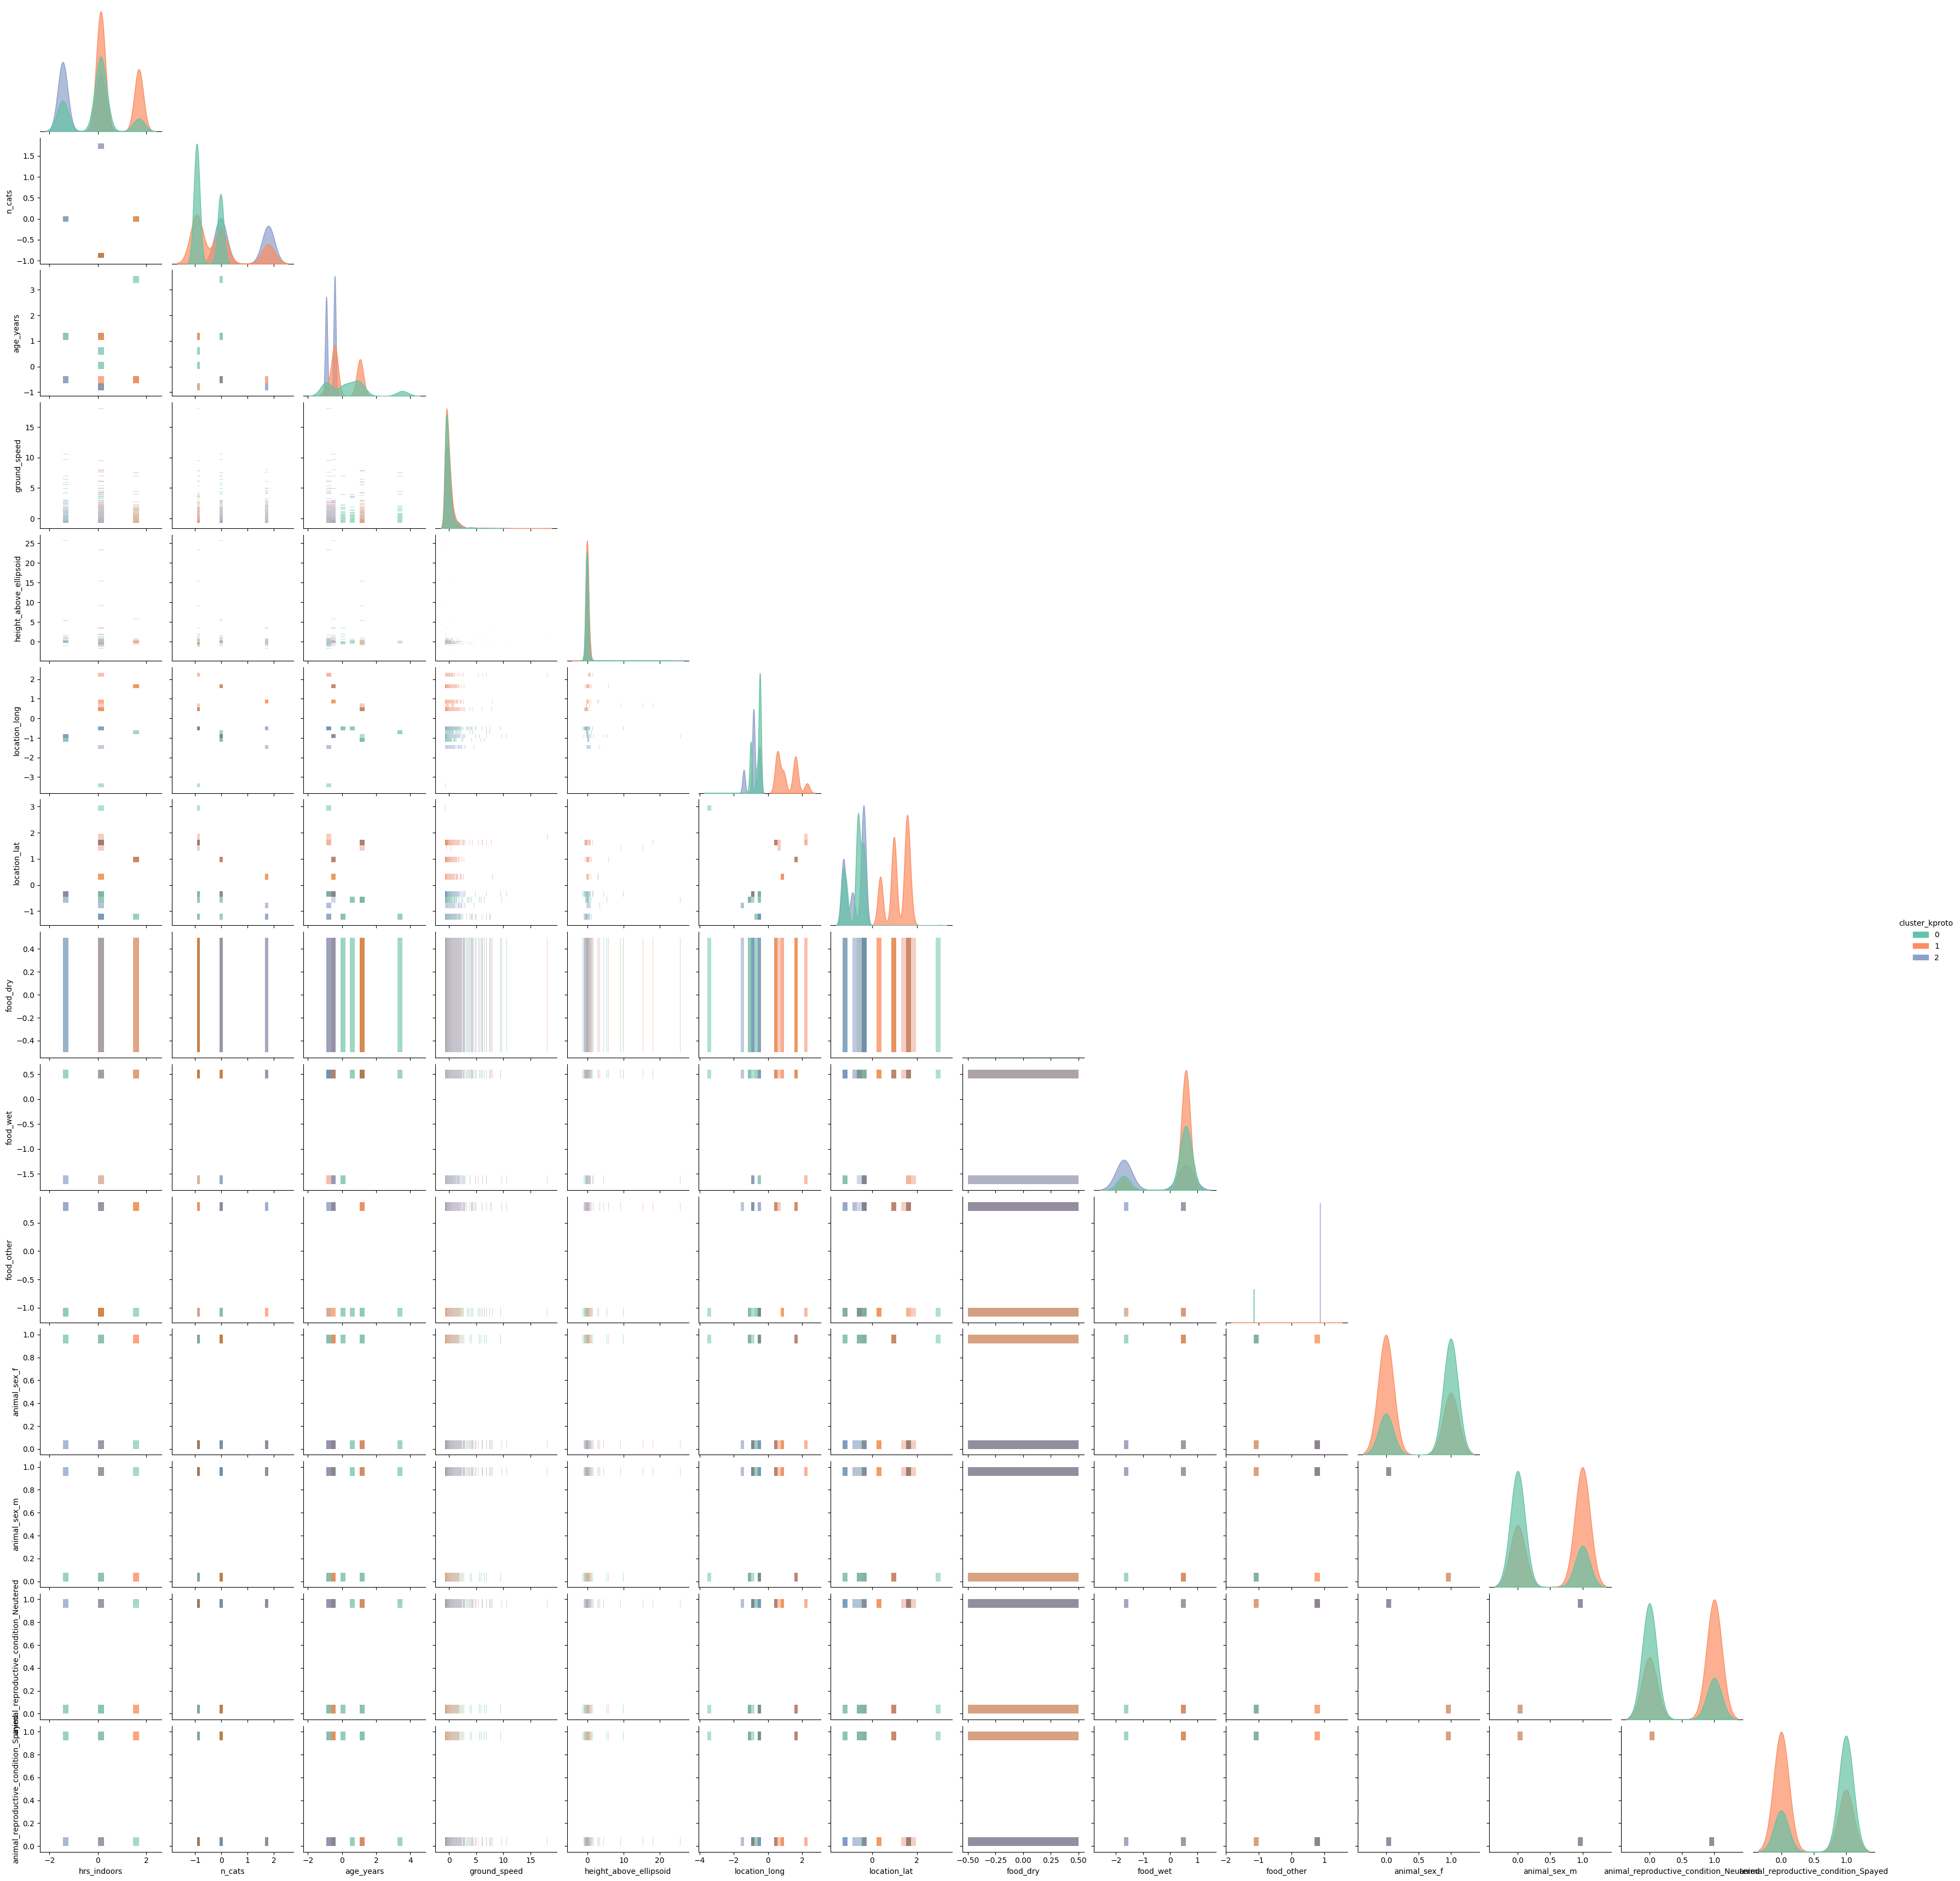

In [21]:
sns.pairplot(features_preprocessed, hue="cluster_kproto",  kind="hist", diag_kind="kde", corner=True, palette="Set2",
    plot_kws={'alpha': 0.7}, # Adjusts transparency of the scatter points (0.0 to 1.0)
    diag_kws={'alpha': 0.7}  # Adjusts transparency of the diagonal plots (histograms/KDEs)
    )

Notice that food_dry is all 0s, which means that all of the cats in extreme_cats have the same value (1 is this case), which all turns into 0 after standard scaling, which means this feature has no importance at all, but in a business perspective, this can be helpful.

# **4. Analyze and Interpret Patterns/Clusters**



In [22]:
cluster_characteristics = features_preprocessed.groupby('cluster_kproto').mean()
display(cluster_characteristics)

,hrs_indoors,n_cats,age_years,ground_speed,height_above_ellipsoid,location_long,location_lat,food_dry,food_wet,food_other,animal_sex_f,animal_sex_m,animal_reproductive_condition_Neutered,animal_reproductive_condition_Spayed
cluster_kproto,,,,,,,,,,,,,,
0,-0.113011,-0.600996,0.483976,-0.066301,-0.060673,-0.626143,-0.718648,0.0,0.167149,-1.159984,0.737500,0.262500,0.262500,0.737500
1,0.661079,-0.115077,0.098165,-0.023104,0.047819,1.147337,1.152222,0.0,0.377994,0.302949,0.340909,0.659091,0.659091,0.340909
2,-0.736347,0.799997,-0.651367,0.101775,0.003561,-0.812524,-0.718740,0.0,-0.671898,0.862081,0.000000,1.000000,1.000000,0.000000


### **4.1 Visualize Findings**



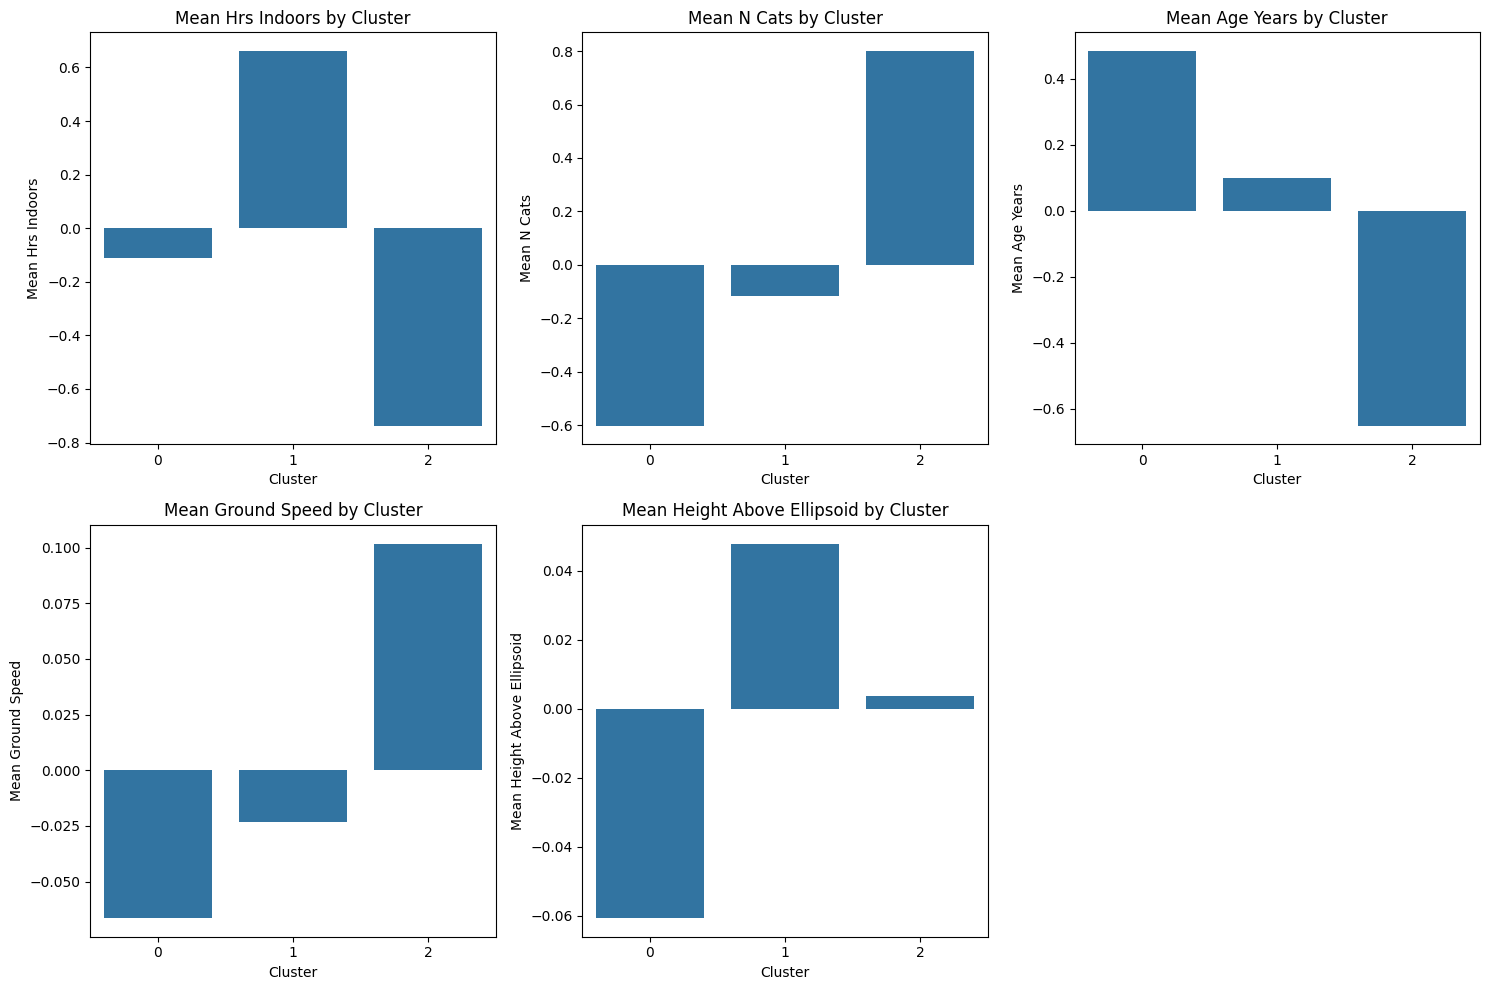

In [23]:
#Numerical features plotting
numerical_features_to_plot = [
    'hrs_indoors', 'n_cats', 'age_years', 'ground_speed', 'height_above_ellipsoid'
]

plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features_to_plot):
    plt.subplot(2, 3, i + 1)
    sns.barplot(x=cluster_characteristics.index, y=feature, data=cluster_characteristics)
    plt.title(f'Mean {feature.replace("_", " ").title()} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Mean {feature.replace("_", " ").title()}')

plt.tight_layout()
plt.show()

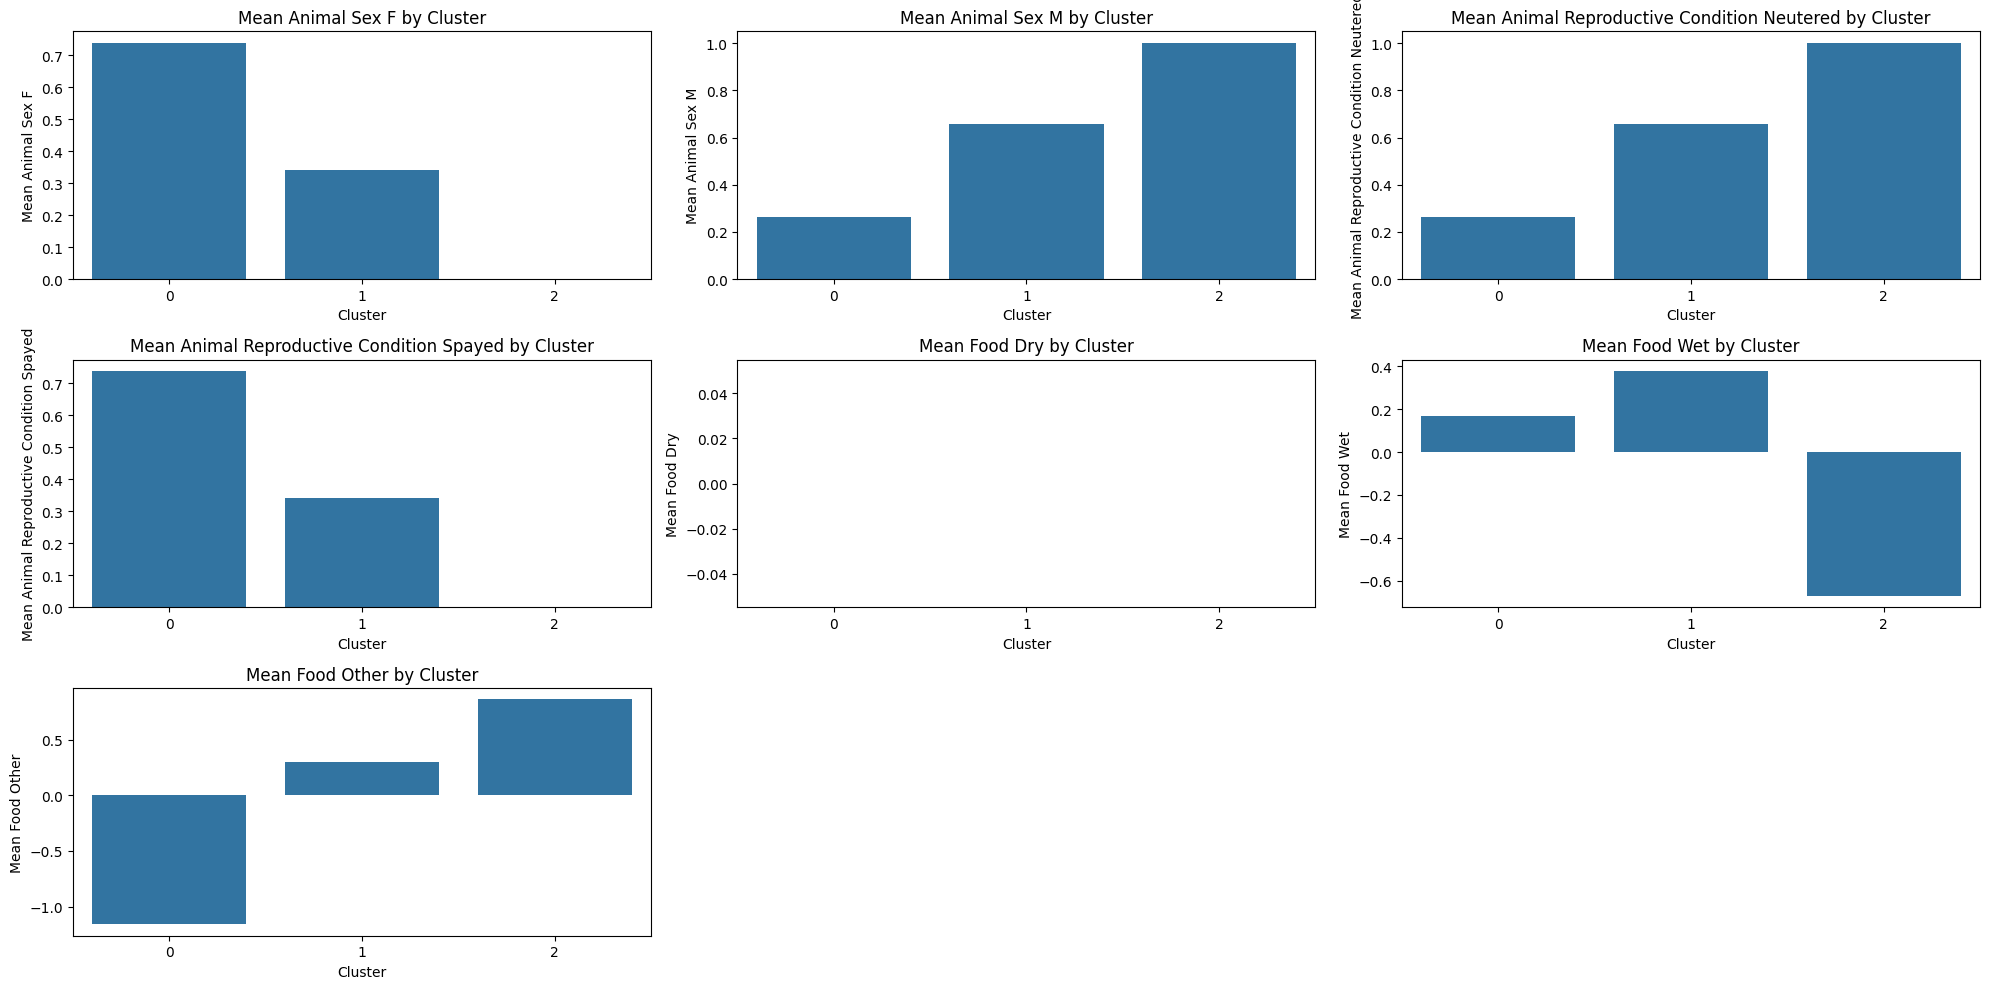

In [24]:
#Categorical features plotting
categorical_features_to_plot = [
    'animal_sex_f', 'animal_sex_m',
    'animal_reproductive_condition_Neutered', 'animal_reproductive_condition_Spayed',
    'food_dry', 'food_wet', 'food_other'
]

plt.figure(figsize=(20, 10))

for i, feature in enumerate(categorical_features_to_plot):
    plt.subplot(3, 3, i + 1)
    sns.barplot(x=cluster_characteristics.index, y=feature, data=cluster_characteristics)
    plt.title(f'Mean {feature.replace("_", " ").title()} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Mean {feature.replace("_", " ").title()}')

plt.tight_layout()
plt.show()

# **5. Next Step PCA Code**


In [44]:
from sklearn.decomposition import PCA

pca = PCA()

features_pca = pca.fit_transform(features_preprocessed)

cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)

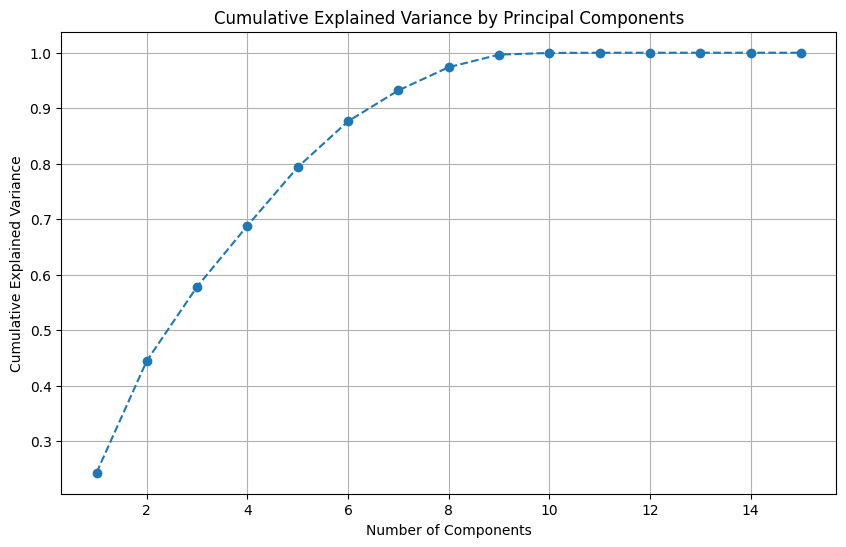

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cum_explained_variance) + 1), cum_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

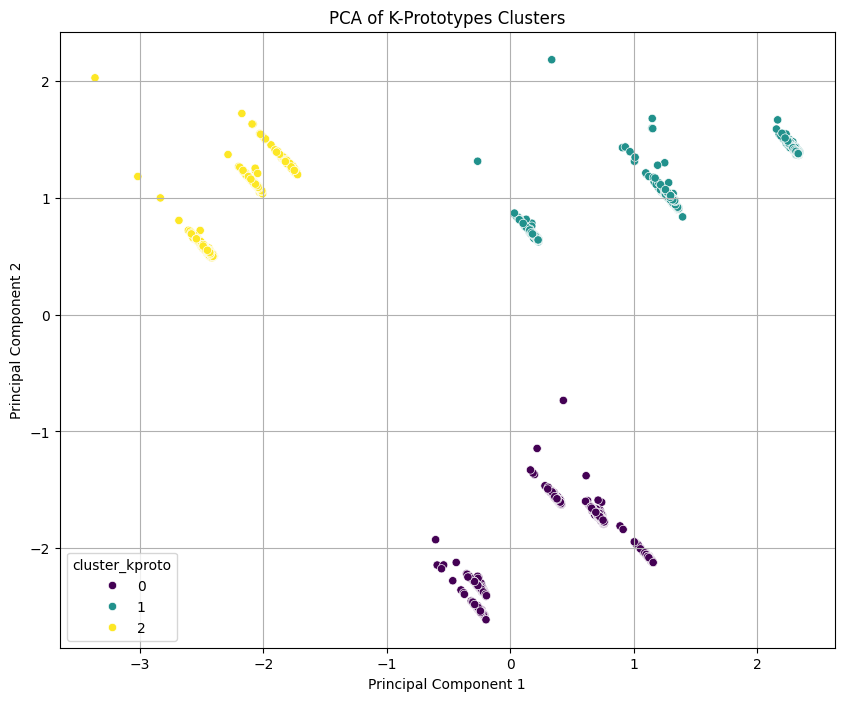

In [46]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=features_pca[:, 0],
    y=features_pca[:, 1],
    hue=features_preprocessed['cluster_kproto'],
    palette='viridis',
    legend='full'
)
plt.title('PCA of K-Prototypes Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

I'll try to get into deeper analysis in future milestones.